In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from keras.engine import input_layer
from keras.models import Sequential
from tensorflow.keras import layers


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#발전기명, 년월일, 설비용량(MW)	01시	02시	03시	04시	05시	06시	07시	08시	09시	10시	11시	12시	13시	14시	15시	16시	17시	18시	19시	20시	21시	22시	23시	24시

dataset1 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_세종.csv', encoding='cp949')
dataset2 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_안산.csv', encoding='cp949')
dataset3 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_영암.csv', encoding='cp949')

dataset1.head()

,발전기명,년월일,설비용량(MW),1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,세종시폐기물매립장태양광,2017-01-01,1.628,0,0,0,0,0,0,0,...,742080,334440,87240,2880,4320,0,0,0,0,0
1,세종시폐기물매립장태양광,2017-01-02,1.628,0,0,0,0,0,0,0,...,606360,501120,158280,2760,3360,0,0,0,0,0
2,세종시폐기물매립장태양광,2017-01-03,1.628,0,0,0,0,0,0,0,...,881040,557040,128640,2280,3000,0,0,0,0,0
3,세종시폐기물매립장태양광,2017-01-04,1.628,0,0,0,0,0,0,0,...,677280,502320,112080,1800,2760,0,0,0,0,0
4,세종시폐기물매립장태양광,2017-01-05,1.628,0,0,0,0,0,0,0,...,259560,138840,45000,2520,2880,0,0,0,0,0


### * nan 값 0으로 대체

In [3]:
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("Before : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

dataset1, dataset2, dataset3 = dataset1.fillna(0), dataset2.fillna(0), dataset3.fillna(0)
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("After : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)


Before :  0 0 0
After :  0 0 0


In [4]:
new_dataset1, new_dataset2, new_dataset3 = [], [], []

for i in range(len(dataset1)):
    new_dataset1.extend(dataset1.iloc[i,3:])

for i in range(len(dataset2)):
    new_dataset2.extend(dataset2.iloc[i,3:])

for i in range(len(dataset3)):
    new_dataset3.extend(dataset3.iloc[i,3:])
    
len(new_dataset1), len(new_dataset2), len(new_dataset3)

(40608, 40608, 40608)

In [5]:
df = pd.DataFrame({'local1':new_dataset1,
                   'local2':new_dataset2,
                   'local3':new_dataset3})


train_dataset = df.sample(frac=0.857,random_state=0)
test_dataset = df.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("local2")
train_stats = train_stats.transpose()
train_stats

#레이블
train_labels = train_dataset.pop('local2')
test_labels = test_dataset.pop('local2')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

normed_train_data = np.array(normed_train_data)
normed_test_data = np.array(normed_test_data)

normed_train_data = np.reshape(normed_train_data, (normed_train_data.shape[0], 1, normed_train_data.shape[1]))
normed_test_data = np.reshape(normed_test_data, (normed_test_data.shape[0], 1, normed_test_data.shape[1]))

In [6]:
normed_test_data

array([[[ 0.15100977,  0.39366978]],

       [[ 0.5967916 ,  1.83767991]],

       [[ 1.65536737,  1.93455271]],

       ...,

       [[-0.65189701, -0.66284916]],

       [[ 0.39825012,  1.52284332]],

       [[-0.65189701, -0.66284916]]])

In [7]:
def build_model():
    model = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(1,len(train_dataset.keys()))),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',  optimizer='adam', metrics=['mae', 'mse'])
    return model

In [8]:
model = build_model()

In [9]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1) #bactch_size

Epoch 1/1000
870/870 [==============================] - 6s 3ms/step - loss: 103363158016.0000 - mae: 161367.3125 - mse: 103363158016.0000 - val_loss: 22233253888.0000 - val_mae: 73190.4609 - val_mse: 22233253888.0000
Epoch 2/1000
870/870 [==============================] - 2s 3ms/step - loss: 19742201856.0000 - mae: 70389.2266 - mse: 19742201856.0000 - val_loss: 20268197888.0000 - val_mae: 72681.0156 - val_mse: 20268197888.0000
Epoch 3/1000
870/870 [==============================] - 2s 2ms/step - loss: 18438922240.0000 - mae: 72523.2812 - mse: 18438922240.0000 - val_loss: 19535122432.0000 - val_mae: 76372.0469 - val_mse: 19535122432.0000
Epoch 4/1000
870/870 [==============================] - 2s 2ms/step - loss: 17960579072.0000 - mae: 74319.0781 - mse: 17960579072.0000 - val_loss: 19151067136.0000 - val_mae: 75784.0781 - val_mse: 19151067136.0000
Epoch 5/1000
870/870 [==============================] - 2s 2ms/step - loss: 17702025216.0000 - mae: 73508.8672 - mse: 17702025216.0000 - val_

870/870 [==============================] - 2s 2ms/step - loss: 17080281088.0000 - mae: 66045.4609 - mse: 17080281088.0000 - val_loss: 18349598720.0000 - val_mae: 67531.4609 - val_mse: 18349598720.0000
Epoch 40/1000
870/870 [==============================] - 2s 2ms/step - loss: 17082442752.0000 - mae: 65958.7031 - mse: 17082442752.0000 - val_loss: 18413785088.0000 - val_mae: 67927.1172 - val_mse: 18413785088.0000
Epoch 41/1000
870/870 [==============================] - 2s 2ms/step - loss: 17082472448.0000 - mae: 65946.5547 - mse: 17082472448.0000 - val_loss: 18401581056.0000 - val_mae: 67598.9141 - val_mse: 18401581056.0000
Epoch 42/1000
870/870 [==============================] - 2s 2ms/step - loss: 17073481728.0000 - mae: 65916.6328 - mse: 17073481728.0000 - val_loss: 18386386944.0000 - val_mae: 67262.1953 - val_mse: 18386386944.0000
Epoch 43/1000
870/870 [==============================] - 2s 2ms/step - loss: 17059356672.0000 - mae: 65847.1250 - mse: 17059356672.0000 - val_loss: 184381

870/870 [==============================] - 2s 2ms/step - loss: 16826075136.0000 - mae: 64774.9453 - mse: 16826075136.0000 - val_loss: 18154752000.0000 - val_mae: 67474.1953 - val_mse: 18154752000.0000
Epoch 78/1000
870/870 [==============================] - 2s 2ms/step - loss: 16830850048.0000 - mae: 64908.2812 - mse: 16830850048.0000 - val_loss: 18117072896.0000 - val_mae: 66182.1953 - val_mse: 18117072896.0000
Epoch 79/1000
870/870 [==============================] - 2s 2ms/step - loss: 16807785472.0000 - mae: 64710.5000 - mse: 16807785472.0000 - val_loss: 18126094336.0000 - val_mae: 66774.6172 - val_mse: 18126094336.0000
Epoch 80/1000
870/870 [==============================] - 2s 2ms/step - loss: 16799910912.0000 - mae: 64716.6328 - mse: 16799910912.0000 - val_loss: 18150162432.0000 - val_mae: 66305.6094 - val_mse: 18150162432.0000
Epoch 81/1000
870/870 [==============================] - 2s 2ms/step - loss: 16793672704.0000 - mae: 64714.4922 - mse: 16793672704.0000 - val_loss: 181109

870/870 [==============================] - 2s 2ms/step - loss: 16591399936.0000 - mae: 64313.9766 - mse: 16591399936.0000 - val_loss: 17942253568.0000 - val_mae: 65930.2812 - val_mse: 17942253568.0000
Epoch 116/1000
870/870 [==============================] - 2s 2ms/step - loss: 16601719808.0000 - mae: 64252.2070 - mse: 16601719808.0000 - val_loss: 17944997888.0000 - val_mae: 65862.6719 - val_mse: 17944997888.0000
Epoch 117/1000
870/870 [==============================] - 2s 2ms/step - loss: 16595980288.0000 - mae: 64326.1016 - mse: 16595980288.0000 - val_loss: 17935175680.0000 - val_mae: 65676.4062 - val_mse: 17935175680.0000
Epoch 118/1000
870/870 [==============================] - 2s 2ms/step - loss: 16598223872.0000 - mae: 64166.6680 - mse: 16598223872.0000 - val_loss: 17942206464.0000 - val_mae: 65742.3984 - val_mse: 17942206464.0000
Epoch 119/1000
870/870 [==============================] - 2s 2ms/step - loss: 16578149376.0000 - mae: 64356.4492 - mse: 16578149376.0000 - val_loss: 17

Epoch 153/1000
870/870 [==============================] - 2s 2ms/step - loss: 16521869312.0000 - mae: 63893.1211 - mse: 16521869312.0000 - val_loss: 17892182016.0000 - val_mae: 65488.7500 - val_mse: 17892182016.0000
Epoch 154/1000
870/870 [==============================] - 2s 3ms/step - loss: 16528786432.0000 - mae: 64034.5039 - mse: 16528786432.0000 - val_loss: 17921939456.0000 - val_mae: 65291.8281 - val_mse: 17921939456.0000
Epoch 155/1000
870/870 [==============================] - 2s 3ms/step - loss: 16535828480.0000 - mae: 63892.9258 - mse: 16535828480.0000 - val_loss: 17886601216.0000 - val_mae: 65843.9844 - val_mse: 17886601216.0000
Epoch 156/1000
870/870 [==============================] - 3s 3ms/step - loss: 16533117952.0000 - mae: 63976.6914 - mse: 16533117952.0000 - val_loss: 17891500032.0000 - val_mae: 65345.9297 - val_mse: 17891500032.0000
Epoch 157/1000
870/870 [==============================] - 2s 3ms/step - loss: 16526914560.0000 - mae: 63977.4609 - mse: 16526914560.0000

Epoch 191/1000
870/870 [==============================] - 2s 3ms/step - loss: 16493528064.0000 - mae: 63784.2383 - mse: 16493528064.0000 - val_loss: 17881137152.0000 - val_mae: 66689.6953 - val_mse: 17881137152.0000
Epoch 192/1000
870/870 [==============================] - 2s 3ms/step - loss: 16506188800.0000 - mae: 63865.4062 - mse: 16506188800.0000 - val_loss: 17866178560.0000 - val_mae: 65900.8906 - val_mse: 17866178560.0000
Epoch 193/1000
870/870 [==============================] - 2s 3ms/step - loss: 16495268864.0000 - mae: 63842.3086 - mse: 16495268864.0000 - val_loss: 17893322752.0000 - val_mae: 65214.8828 - val_mse: 17893322752.0000
Epoch 194/1000
870/870 [==============================] - 2s 3ms/step - loss: 16498193408.0000 - mae: 63848.6797 - mse: 16498193408.0000 - val_loss: 17868646400.0000 - val_mae: 65176.8750 - val_mse: 17868646400.0000
Epoch 195/1000
870/870 [==============================] - 2s 3ms/step - loss: 16478314496.0000 - mae: 63703.9023 - mse: 16478314496.0000

Epoch 229/1000
870/870 [==============================] - 2s 3ms/step - loss: 16476064768.0000 - mae: 63769.2773 - mse: 16476064768.0000 - val_loss: 17891540992.0000 - val_mae: 65121.4883 - val_mse: 17891540992.0000
Epoch 230/1000
870/870 [==============================] - 2s 3ms/step - loss: 16472545280.0000 - mae: 63720.1602 - mse: 16472545280.0000 - val_loss: 17871144960.0000 - val_mae: 65267.6953 - val_mse: 17871144960.0000
Epoch 231/1000
870/870 [==============================] - 2s 3ms/step - loss: 16470669312.0000 - mae: 63656.6836 - mse: 16470669312.0000 - val_loss: 17871118336.0000 - val_mae: 65672.8438 - val_mse: 17871118336.0000
Epoch 232/1000
870/870 [==============================] - 2s 3ms/step - loss: 16473636864.0000 - mae: 63777.2188 - mse: 16473636864.0000 - val_loss: 17877338112.0000 - val_mae: 65993.8359 - val_mse: 17877338112.0000
Epoch 233/1000
870/870 [==============================] - 2s 3ms/step - loss: 16466828288.0000 - mae: 63764.1250 - mse: 16466828288.0000

Epoch 267/1000
870/870 [==============================] - 3s 3ms/step - loss: 16462513152.0000 - mae: 63785.9766 - mse: 16462513152.0000 - val_loss: 17875144704.0000 - val_mae: 64882.9414 - val_mse: 17875144704.0000
Epoch 268/1000
870/870 [==============================] - 3s 4ms/step - loss: 16458303488.0000 - mae: 63686.2383 - mse: 16458303488.0000 - val_loss: 17975584768.0000 - val_mae: 64800.2500 - val_mse: 17975584768.0000
Epoch 269/1000
870/870 [==============================] - 3s 4ms/step - loss: 16478753792.0000 - mae: 63659.2773 - mse: 16478753792.0000 - val_loss: 17873715200.0000 - val_mae: 65475.1484 - val_mse: 17873715200.0000
Epoch 270/1000
870/870 [==============================] - 3s 4ms/step - loss: 16475310080.0000 - mae: 63794.3164 - mse: 16475310080.0000 - val_loss: 17934749696.0000 - val_mae: 65242.3125 - val_mse: 17934749696.0000
Epoch 271/1000
870/870 [==============================] - 3s 3ms/step - loss: 16466567168.0000 - mae: 63722.8008 - mse: 16466567168.0000

Epoch 305/1000
870/870 [==============================] - 3s 3ms/step - loss: 16466593792.0000 - mae: 63702.4414 - mse: 16466593792.0000 - val_loss: 17904248832.0000 - val_mae: 65289.2305 - val_mse: 17904248832.0000
Epoch 306/1000
870/870 [==============================] - 3s 4ms/step - loss: 16451860480.0000 - mae: 63688.5664 - mse: 16451860480.0000 - val_loss: 17902960640.0000 - val_mae: 65251.0703 - val_mse: 17902960640.0000
Epoch 307/1000
870/870 [==============================] - 3s 4ms/step - loss: 16468497408.0000 - mae: 63663.3281 - mse: 16468497408.0000 - val_loss: 17909852160.0000 - val_mae: 65526.5273 - val_mse: 17909852160.0000
Epoch 308/1000
870/870 [==============================] - 3s 4ms/step - loss: 16471394304.0000 - mae: 63731.8242 - mse: 16471394304.0000 - val_loss: 17880903680.0000 - val_mae: 65307.7852 - val_mse: 17880903680.0000
Epoch 309/1000
870/870 [==============================] - 3s 3ms/step - loss: 16456697856.0000 - mae: 63642.0234 - mse: 16456697856.0000

Epoch 343/1000
870/870 [==============================] - 3s 3ms/step - loss: 16457838592.0000 - mae: 63725.5352 - mse: 16457838592.0000 - val_loss: 17887811584.0000 - val_mae: 65429.0664 - val_mse: 17887811584.0000
Epoch 344/1000
870/870 [==============================] - 3s 3ms/step - loss: 16456141824.0000 - mae: 63706.2109 - mse: 16456141824.0000 - val_loss: 17916919808.0000 - val_mae: 65197.3438 - val_mse: 17916919808.0000
Epoch 345/1000
870/870 [==============================] - 3s 3ms/step - loss: 16458504192.0000 - mae: 63675.0664 - mse: 16458504192.0000 - val_loss: 18040008704.0000 - val_mae: 65718.0625 - val_mse: 18040008704.0000
Epoch 346/1000
870/870 [==============================] - 3s 3ms/step - loss: 16465949696.0000 - mae: 63697.0117 - mse: 16465949696.0000 - val_loss: 17923911680.0000 - val_mae: 65413.5703 - val_mse: 17923911680.0000
Epoch 347/1000
870/870 [==============================] - 3s 3ms/step - loss: 16469318656.0000 - mae: 63708.1367 - mse: 16469318656.0000

Epoch 381/1000
870/870 [==============================] - 3s 3ms/step - loss: 16458379264.0000 - mae: 63559.3945 - mse: 16458379264.0000 - val_loss: 17898403840.0000 - val_mae: 65566.1406 - val_mse: 17898403840.0000
Epoch 382/1000
870/870 [==============================] - 3s 3ms/step - loss: 16466952192.0000 - mae: 63714.7070 - mse: 16466952192.0000 - val_loss: 17899945984.0000 - val_mae: 65573.2344 - val_mse: 17899945984.0000
Epoch 383/1000
870/870 [==============================] - 3s 3ms/step - loss: 16450475008.0000 - mae: 63735.8789 - mse: 16450475008.0000 - val_loss: 17894942720.0000 - val_mae: 65468.9141 - val_mse: 17894942720.0000
Epoch 384/1000
870/870 [==============================] - 3s 3ms/step - loss: 16454558720.0000 - mae: 63685.1680 - mse: 16454558720.0000 - val_loss: 17895567360.0000 - val_mae: 65539.0000 - val_mse: 17895567360.0000
Epoch 385/1000
870/870 [==============================] - 3s 3ms/step - loss: 16465720320.0000 - mae: 63684.3320 - mse: 16465720320.0000

Epoch 419/1000
870/870 [==============================] - 3s 4ms/step - loss: 16461323264.0000 - mae: 63728.3711 - mse: 16461323264.0000 - val_loss: 17909217280.0000 - val_mae: 65026.3164 - val_mse: 17909217280.0000
Epoch 420/1000
870/870 [==============================] - 3s 4ms/step - loss: 16460628992.0000 - mae: 63662.9141 - mse: 16460628992.0000 - val_loss: 17903853568.0000 - val_mae: 65203.8281 - val_mse: 17903853568.0000
Epoch 421/1000
870/870 [==============================] - 3s 3ms/step - loss: 16467375104.0000 - mae: 63693.2539 - mse: 16467375104.0000 - val_loss: 17903935488.0000 - val_mae: 65140.9961 - val_mse: 17903935488.0000
Epoch 422/1000
870/870 [==============================] - 4s 4ms/step - loss: 16463758336.0000 - mae: 63660.6055 - mse: 16463758336.0000 - val_loss: 17918550016.0000 - val_mae: 65546.0625 - val_mse: 17918550016.0000
Epoch 423/1000
870/870 [==============================] - 3s 3ms/step - loss: 16459982848.0000 - mae: 63653.9414 - mse: 16459982848.0000

Epoch 457/1000
870/870 [==============================] - 3s 3ms/step - loss: 16456384512.0000 - mae: 63674.7461 - mse: 16456384512.0000 - val_loss: 17970268160.0000 - val_mae: 66494.7734 - val_mse: 17970268160.0000
Epoch 458/1000
870/870 [==============================] - 3s 3ms/step - loss: 16457188352.0000 - mae: 63714.4375 - mse: 16457188352.0000 - val_loss: 17931472896.0000 - val_mae: 65816.5547 - val_mse: 17931472896.0000
Epoch 459/1000
870/870 [==============================] - 3s 3ms/step - loss: 16450181120.0000 - mae: 63682.9453 - mse: 16450181120.0000 - val_loss: 17910665216.0000 - val_mae: 65524.8789 - val_mse: 17910665216.0000
Epoch 460/1000
870/870 [==============================] - 3s 3ms/step - loss: 16449473536.0000 - mae: 63643.3789 - mse: 16449473536.0000 - val_loss: 17906053120.0000 - val_mae: 65154.5000 - val_mse: 17906053120.0000
Epoch 461/1000
870/870 [==============================] - 3s 3ms/step - loss: 16452796416.0000 - mae: 63651.1523 - mse: 16452796416.0000

Epoch 495/1000
870/870 [==============================] - 3s 3ms/step - loss: 16457026560.0000 - mae: 63647.5742 - mse: 16457026560.0000 - val_loss: 17928372224.0000 - val_mae: 65706.4688 - val_mse: 17928372224.0000
Epoch 496/1000
870/870 [==============================] - 2s 3ms/step - loss: 16452754432.0000 - mae: 63678.6484 - mse: 16452754432.0000 - val_loss: 17967896576.0000 - val_mae: 65993.4062 - val_mse: 17967896576.0000
Epoch 497/1000
870/870 [==============================] - 2s 3ms/step - loss: 16464815104.0000 - mae: 63702.4570 - mse: 16464815104.0000 - val_loss: 17910362112.0000 - val_mae: 65486.3945 - val_mse: 17910362112.0000
Epoch 498/1000
870/870 [==============================] - 2s 3ms/step - loss: 16453577728.0000 - mae: 63692.6797 - mse: 16453577728.0000 - val_loss: 17930565632.0000 - val_mae: 65354.4062 - val_mse: 17930565632.0000
Epoch 499/1000
870/870 [==============================] - 3s 3ms/step - loss: 16461164544.0000 - mae: 63667.8164 - mse: 16461164544.0000

Epoch 533/1000
870/870 [==============================] - 2s 3ms/step - loss: 16455004160.0000 - mae: 63723.4180 - mse: 16455004160.0000 - val_loss: 17919031296.0000 - val_mae: 65058.4531 - val_mse: 17919031296.0000
Epoch 534/1000
870/870 [==============================] - 2s 3ms/step - loss: 16447546368.0000 - mae: 63638.8320 - mse: 16447546368.0000 - val_loss: 17915658240.0000 - val_mae: 65243.4258 - val_mse: 17915658240.0000
Epoch 535/1000
870/870 [==============================] - 2s 3ms/step - loss: 16458327040.0000 - mae: 63675.8594 - mse: 16458327040.0000 - val_loss: 17915244544.0000 - val_mae: 66015.8516 - val_mse: 17915244544.0000
Epoch 536/1000
870/870 [==============================] - 2s 3ms/step - loss: 16453888000.0000 - mae: 63747.8477 - mse: 16453888000.0000 - val_loss: 17924345856.0000 - val_mae: 65019.4609 - val_mse: 17924345856.0000
Epoch 537/1000
870/870 [==============================] - 2s 3ms/step - loss: 16461739008.0000 - mae: 63682.1797 - mse: 16461739008.0000

Epoch 571/1000
870/870 [==============================] - 2s 3ms/step - loss: 16463091712.0000 - mae: 63648.1328 - mse: 16463091712.0000 - val_loss: 17911126016.0000 - val_mae: 65538.4141 - val_mse: 17911126016.0000
Epoch 572/1000
870/870 [==============================] - 2s 3ms/step - loss: 16461418496.0000 - mae: 63662.9023 - mse: 16461418496.0000 - val_loss: 17914855424.0000 - val_mae: 65731.0547 - val_mse: 17914855424.0000
Epoch 573/1000
870/870 [==============================] - 2s 2ms/step - loss: 16446888960.0000 - mae: 63684.6680 - mse: 16446888960.0000 - val_loss: 17971011584.0000 - val_mae: 65035.9414 - val_mse: 17971011584.0000
Epoch 574/1000
870/870 [==============================] - 3s 3ms/step - loss: 16459776000.0000 - mae: 63679.5156 - mse: 16459776000.0000 - val_loss: 17914873856.0000 - val_mae: 65263.2578 - val_mse: 17914873856.0000
Epoch 575/1000
870/870 [==============================] - 2s 3ms/step - loss: 16457103360.0000 - mae: 63648.8008 - mse: 16457103360.0000

Epoch 609/1000
870/870 [==============================] - 2s 2ms/step - loss: 16456762368.0000 - mae: 63674.4375 - mse: 16456762368.0000 - val_loss: 17922684928.0000 - val_mae: 65374.2422 - val_mse: 17922684928.0000
Epoch 610/1000
870/870 [==============================] - 2s 2ms/step - loss: 16459110400.0000 - mae: 63767.1016 - mse: 16459110400.0000 - val_loss: 17938665472.0000 - val_mae: 65162.8672 - val_mse: 17938665472.0000
Epoch 611/1000
870/870 [==============================] - 2s 2ms/step - loss: 16448640000.0000 - mae: 63604.9062 - mse: 16448640000.0000 - val_loss: 17919604736.0000 - val_mae: 65375.4062 - val_mse: 17919604736.0000
Epoch 612/1000
870/870 [==============================] - 2s 2ms/step - loss: 16455357440.0000 - mae: 63702.2617 - mse: 16455357440.0000 - val_loss: 17914390528.0000 - val_mae: 65077.1680 - val_mse: 17914390528.0000
Epoch 613/1000
870/870 [==============================] - 2s 2ms/step - loss: 16444680192.0000 - mae: 63633.0859 - mse: 16444680192.0000

Epoch 647/1000
870/870 [==============================] - 1s 2ms/step - loss: 16458943488.0000 - mae: 63766.6133 - mse: 16458943488.0000 - val_loss: 17918722048.0000 - val_mae: 65347.3281 - val_mse: 17918722048.0000
Epoch 648/1000
870/870 [==============================] - 1s 2ms/step - loss: 16457365504.0000 - mae: 63717.8867 - mse: 16457365504.0000 - val_loss: 17920075776.0000 - val_mae: 65282.8438 - val_mse: 17920075776.0000
Epoch 649/1000
870/870 [==============================] - 2s 2ms/step - loss: 16457157632.0000 - mae: 63616.3047 - mse: 16457157632.0000 - val_loss: 17920876544.0000 - val_mae: 65655.6719 - val_mse: 17920876544.0000
Epoch 650/1000
870/870 [==============================] - 1s 2ms/step - loss: 16454511616.0000 - mae: 63669.3242 - mse: 16454511616.0000 - val_loss: 17983864832.0000 - val_mae: 65899.4922 - val_mse: 17983864832.0000
Epoch 651/1000
870/870 [==============================] - 1s 2ms/step - loss: 16467761152.0000 - mae: 63753.9141 - mse: 16467761152.0000

Epoch 685/1000
870/870 [==============================] - 2s 2ms/step - loss: 16461845504.0000 - mae: 63671.0820 - mse: 16461845504.0000 - val_loss: 17991579648.0000 - val_mae: 67017.0078 - val_mse: 17991579648.0000
Epoch 686/1000
870/870 [==============================] - 2s 2ms/step - loss: 16455241728.0000 - mae: 63650.5742 - mse: 16455241728.0000 - val_loss: 17924925440.0000 - val_mae: 65581.8125 - val_mse: 17924925440.0000
Epoch 687/1000
870/870 [==============================] - 1s 2ms/step - loss: 16453767168.0000 - mae: 63709.4180 - mse: 16453767168.0000 - val_loss: 17933127680.0000 - val_mae: 65385.2227 - val_mse: 17933127680.0000
Epoch 688/1000
870/870 [==============================] - 1s 2ms/step - loss: 16463992832.0000 - mae: 63731.7227 - mse: 16463992832.0000 - val_loss: 17919365120.0000 - val_mae: 65116.1094 - val_mse: 17919365120.0000
Epoch 689/1000
870/870 [==============================] - 2s 2ms/step - loss: 16452360192.0000 - mae: 63609.8633 - mse: 16452360192.0000

Epoch 723/1000
870/870 [==============================] - 1s 2ms/step - loss: 16435679232.0000 - mae: 63574.6758 - mse: 16435679232.0000 - val_loss: 17918529536.0000 - val_mae: 65417.7305 - val_mse: 17918529536.0000
Epoch 724/1000
870/870 [==============================] - 1s 2ms/step - loss: 16444289024.0000 - mae: 63655.0117 - mse: 16444289024.0000 - val_loss: 17959196672.0000 - val_mae: 65837.8203 - val_mse: 17959196672.0000
Epoch 725/1000
870/870 [==============================] - 1s 2ms/step - loss: 16452900864.0000 - mae: 63708.5508 - mse: 16452900864.0000 - val_loss: 17934368768.0000 - val_mae: 65317.0234 - val_mse: 17934368768.0000
Epoch 726/1000
870/870 [==============================] - 1s 2ms/step - loss: 16453222400.0000 - mae: 63613.8242 - mse: 16453222400.0000 - val_loss: 17916014592.0000 - val_mae: 65454.6875 - val_mse: 17916014592.0000
Epoch 727/1000
870/870 [==============================] - 1s 2ms/step - loss: 16452939776.0000 - mae: 63664.0078 - mse: 16452939776.0000

Epoch 761/1000
870/870 [==============================] - 2s 2ms/step - loss: 16449719296.0000 - mae: 63647.8438 - mse: 16449719296.0000 - val_loss: 17927114752.0000 - val_mae: 65421.7461 - val_mse: 17927114752.0000
Epoch 762/1000
870/870 [==============================] - 2s 2ms/step - loss: 16447352832.0000 - mae: 63572.2656 - mse: 16447352832.0000 - val_loss: 17923153920.0000 - val_mae: 65544.7969 - val_mse: 17923153920.0000
Epoch 763/1000
870/870 [==============================] - 2s 2ms/step - loss: 16448760832.0000 - mae: 63640.7109 - mse: 16448760832.0000 - val_loss: 17953552384.0000 - val_mae: 66323.1953 - val_mse: 17953552384.0000
Epoch 764/1000
870/870 [==============================] - 2s 2ms/step - loss: 16443469824.0000 - mae: 63713.9062 - mse: 16443469824.0000 - val_loss: 17929011200.0000 - val_mae: 65294.2930 - val_mse: 17929011200.0000
Epoch 765/1000
870/870 [==============================] - 2s 2ms/step - loss: 16456465408.0000 - mae: 63678.2148 - mse: 16456465408.0000

Epoch 799/1000
870/870 [==============================] - 3s 3ms/step - loss: 16448768000.0000 - mae: 63593.0312 - mse: 16448768000.0000 - val_loss: 17945831424.0000 - val_mae: 65405.7148 - val_mse: 17945831424.0000
Epoch 800/1000
870/870 [==============================] - 3s 3ms/step - loss: 16438572032.0000 - mae: 63622.1016 - mse: 16438572032.0000 - val_loss: 17971787776.0000 - val_mae: 65278.8125 - val_mse: 17971787776.0000
Epoch 801/1000
870/870 [==============================] - 3s 3ms/step - loss: 16442747904.0000 - mae: 63636.8984 - mse: 16442747904.0000 - val_loss: 18016548864.0000 - val_mae: 65555.1562 - val_mse: 18016548864.0000
Epoch 802/1000
870/870 [==============================] - 3s 3ms/step - loss: 16452698112.0000 - mae: 63644.7734 - mse: 16452698112.0000 - val_loss: 17921632256.0000 - val_mae: 65412.4883 - val_mse: 17921632256.0000
Epoch 803/1000
870/870 [==============================] - 3s 3ms/step - loss: 16454967296.0000 - mae: 63705.8203 - mse: 16454967296.0000

Epoch 837/1000
870/870 [==============================] - 3s 3ms/step - loss: 16448847872.0000 - mae: 63686.8594 - mse: 16448847872.0000 - val_loss: 17923086336.0000 - val_mae: 65095.2109 - val_mse: 17923086336.0000
Epoch 838/1000
870/870 [==============================] - 3s 4ms/step - loss: 16436433920.0000 - mae: 63622.9883 - mse: 16436433920.0000 - val_loss: 17925359616.0000 - val_mae: 65175.2422 - val_mse: 17925359616.0000
Epoch 839/1000
870/870 [==============================] - 3s 4ms/step - loss: 16458423296.0000 - mae: 63706.1367 - mse: 16458423296.0000 - val_loss: 17928380416.0000 - val_mae: 65171.2305 - val_mse: 17928380416.0000
Epoch 840/1000
870/870 [==============================] - 3s 3ms/step - loss: 16452338688.0000 - mae: 63668.3125 - mse: 16452338688.0000 - val_loss: 17921148928.0000 - val_mae: 65581.2812 - val_mse: 17921148928.0000
Epoch 841/1000
870/870 [==============================] - 3s 4ms/step - loss: 16456982528.0000 - mae: 63646.0273 - mse: 16456982528.0000

Epoch 875/1000
870/870 [==============================] - 3s 3ms/step - loss: 16449762304.0000 - mae: 63618.1484 - mse: 16449762304.0000 - val_loss: 17924143104.0000 - val_mae: 66392.8516 - val_mse: 17924143104.0000
Epoch 876/1000
870/870 [==============================] - 3s 3ms/step - loss: 16445281280.0000 - mae: 63712.5508 - mse: 16445281280.0000 - val_loss: 17929660416.0000 - val_mae: 65151.0273 - val_mse: 17929660416.0000
Epoch 877/1000
870/870 [==============================] - 2s 3ms/step - loss: 16445205504.0000 - mae: 63576.7305 - mse: 16445205504.0000 - val_loss: 17923260416.0000 - val_mae: 66001.8750 - val_mse: 17923260416.0000
Epoch 878/1000
870/870 [==============================] - 2s 3ms/step - loss: 16446031872.0000 - mae: 63637.9453 - mse: 16446031872.0000 - val_loss: 17927720960.0000 - val_mae: 65476.2734 - val_mse: 17927720960.0000
Epoch 879/1000
870/870 [==============================] - 2s 3ms/step - loss: 16449091584.0000 - mae: 63661.9688 - mse: 16449091584.0000

Epoch 913/1000
870/870 [==============================] - 3s 3ms/step - loss: 16439673856.0000 - mae: 63614.3203 - mse: 16439673856.0000 - val_loss: 17984161792.0000 - val_mae: 66489.5312 - val_mse: 17984161792.0000
Epoch 914/1000
870/870 [==============================] - 3s 3ms/step - loss: 16438596608.0000 - mae: 63620.5938 - mse: 16438596608.0000 - val_loss: 17947412480.0000 - val_mae: 65683.1406 - val_mse: 17947412480.0000
Epoch 915/1000
870/870 [==============================] - 3s 3ms/step - loss: 16445110272.0000 - mae: 63694.6523 - mse: 16445110272.0000 - val_loss: 17953597440.0000 - val_mae: 65898.1016 - val_mse: 17953597440.0000
Epoch 916/1000
870/870 [==============================] - 3s 3ms/step - loss: 16451971072.0000 - mae: 63645.7734 - mse: 16451971072.0000 - val_loss: 17959141376.0000 - val_mae: 65625.8438 - val_mse: 17959141376.0000
Epoch 917/1000
870/870 [==============================] - 2s 3ms/step - loss: 16433611776.0000 - mae: 63653.3867 - mse: 16433611776.0000

Epoch 951/1000
870/870 [==============================] - 2s 3ms/step - loss: 16430706688.0000 - mae: 63767.6680 - mse: 16430706688.0000 - val_loss: 18050244608.0000 - val_mae: 65599.0547 - val_mse: 18050244608.0000
Epoch 952/1000
870/870 [==============================] - 2s 3ms/step - loss: 16447030272.0000 - mae: 63623.9688 - mse: 16447030272.0000 - val_loss: 17930860544.0000 - val_mae: 65187.9766 - val_mse: 17930860544.0000
Epoch 953/1000
870/870 [==============================] - 2s 3ms/step - loss: 16446827520.0000 - mae: 63654.5781 - mse: 16446827520.0000 - val_loss: 17953728512.0000 - val_mae: 64955.6914 - val_mse: 17953728512.0000
Epoch 954/1000
870/870 [==============================] - 3s 3ms/step - loss: 16449233920.0000 - mae: 63624.9922 - mse: 16449233920.0000 - val_loss: 17928896512.0000 - val_mae: 65671.4141 - val_mse: 17928896512.0000
Epoch 955/1000
870/870 [==============================] - 3s 3ms/step - loss: 16433099776.0000 - mae: 63597.1602 - mse: 16433099776.0000

Epoch 989/1000
870/870 [==============================] - 3s 3ms/step - loss: 16441209856.0000 - mae: 63574.2539 - mse: 16441209856.0000 - val_loss: 17946103808.0000 - val_mae: 66194.0312 - val_mse: 17946103808.0000
Epoch 990/1000
870/870 [==============================] - 3s 3ms/step - loss: 16446205952.0000 - mae: 63695.8359 - mse: 16446205952.0000 - val_loss: 17932341248.0000 - val_mae: 65101.3906 - val_mse: 17932341248.0000
Epoch 991/1000
870/870 [==============================] - 3s 3ms/step - loss: 16446034944.0000 - mae: 63645.6914 - mse: 16446034944.0000 - val_loss: 17937027072.0000 - val_mae: 65074.5078 - val_mse: 17937027072.0000
Epoch 992/1000
870/870 [==============================] - 3s 4ms/step - loss: 16428592128.0000 - mae: 63570.1055 - mse: 16428592128.0000 - val_loss: 17934391296.0000 - val_mae: 66028.4844 - val_mse: 17934391296.0000
Epoch 993/1000
870/870 [==============================] - 3s 3ms/step - loss: 16451733504.0000 - mae: 63692.3438 - mse: 16451733504.0000

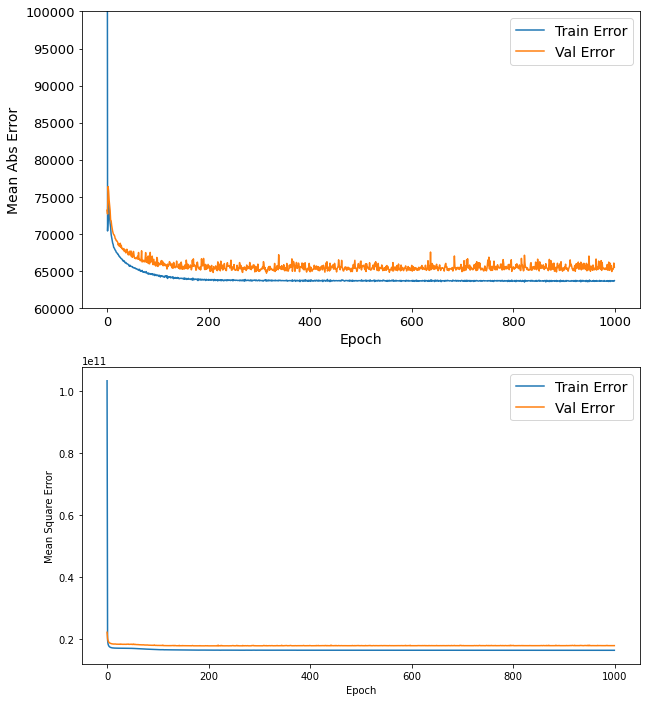

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Mean Abs Error', fontsize=14)
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([60000,100000])
    plt.legend(fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    #plt.ylim([0,20000])
    plt.legend(fontsize=14)
    plt.show()

plot_history(history)

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} local1".format(mae))

182/182 - 0s - loss: 16404922368.0000 - mae: 62592.6680 - mse: 16404922368.0000 - 292ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차: 62592.67 local1


In [ ]:
#plot-------------------------------------------------
scaler = MinMaxScaler(feature_range=(0,1))


trainPredict = model.predict(normed_train_data)
testPredict = model.predict(normed_test_data)

#trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([train_labels])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([test_labels])
look_back = 1

trainPredict_plot = np.empty_like(df['local1'])
trainPredict_plot = trainPredict_plot.reshape(-1,1)
trainPredict_plot[look_back:len(trainPredict)+look_back] = trainPredict

testPredict_plot = np.empty_like(df['local1'])
testPredict_plot = testPredict_plot.reshape(-1,1)
testPredict_plot[len(trainPredict):len(df['local1'])] = testPredict

plt.figure(figsize=(15,8))
plt.plot(df['local1'], label='Local1')

plt.plot(trainPredict_plot, label='Train predict')
#plt.plot(testPredict_plot, label='Test predict')
plt.legend()
plt.show()